<a href="https://colab.research.google.com/github/melissaortegaa/monografia/blob/main/01_data_prep_%26_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

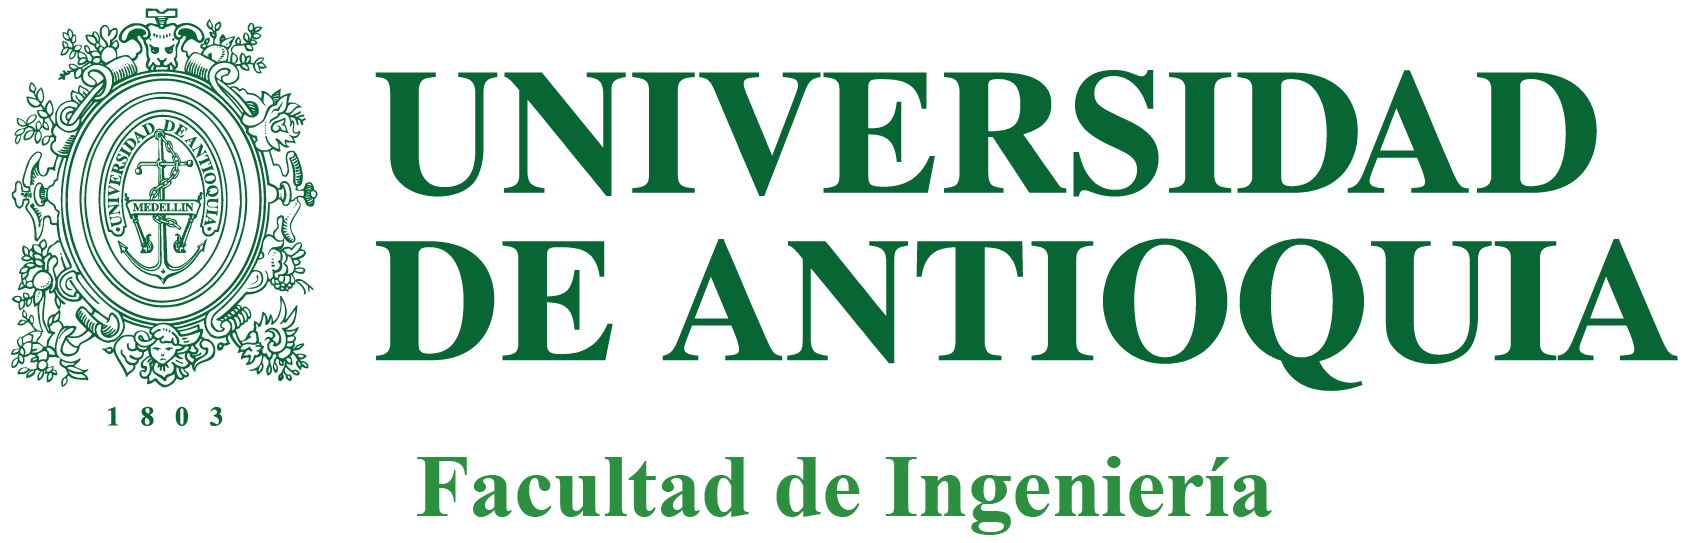
---

**Especialización en Analítica y Ciencia de Datos**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---


<div style="display: flex; align-items: center; justify-content: flex-end; position: fixed; bottom: 10px; right: 10px;">
  <a href="https://colab.research.google.com/github/tu-usuario/tu-repositorio" style="margin-right: 15px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 25px;">
  </a>
  <a href="https://github.com/melissaortegaa/monografia" style="margin-right: 15px;">
    <img src="https://img.shields.io/badge/GitHub-000?logo=github&logoColor=fff&style=flat" alt="View on GitHub" style="height: 25px;">
  </a>
  <a href="https://www.kaggle.com/code/melissaortegaalzate/04-transfer-learning-ipynb">
    <img src="https://img.shields.io/badge/Kaggle-20BEFF?logo=kaggle&logoColor=fff&style=flat" alt="View on Kaggle" style="height: 25px;">
  </a>
</div>

# Objectives

1. Preparar un conjunto de imágenes y sus etiquetas para su posterior utilización en un algoritmo de Machine Learning, específicamente Redes Neuronales Convolucionales.

# Summary

Primero se importan las librerías necesarias y se define una función para visualizar diagramas de barras y figuras aleatorias del conjunto de imágenes.

Luego se prepara el conjunto de datos de imágenes para su posterior uso en modelo de aprendizaje profundo. Descarga, extrae y divide las imágenes en dos clases y conjuntos de entrenamiento, validación y prueba. Luego, copia las imágenes en las carpetas correspondientes y comprime la carpeta en un archivo ZIP. También verifica y muestra el número total de imágenes por clase antes y después de la reestructuración del directorio.

A continuación, se carga y limpia el archivo que contiene las etiquetas de las imágenes, procedimiento que incluye conocer el tamaño y tipo de datos de cada columna, verificar duplicados y cambiar el nombre de las columnas. Así como, el número de imágenes en la carpeta, su tamaño, formato y tipo.

Más adelante se encuentra la sección de visualización, allí se grafica un diagrama de barras para para visualizar la distribución de instancias respecto a las categorías de la variable de salida. Además, se usa la función definida que permite ver imágenes aleatorias para conocer 16 imágenes y sus clases.

# Libraries & Settings

In [1]:
# Standard library imports
import os
import random
import shutil
import zipfile
import glob

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Data manipulation and processing
import numpy as np
import pandas as pd
import cv2

# Deep learning frameworks and utilities
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model

# Warnings configuration
import warnings
warnings.filterwarnings('ignore')

# Function definition

In [2]:
# Funtion to plot images characteristics
def bar_plot(df, target_var, title):
  '''
    Returns the figure build from input parameters.

      Parameters:
              df          [dataframe]  Features dataframe.
              target_var  [string]     Name of column of target variable or feature.
              title       [string]     Title for figure

      Returns:
              Plot of figure
  '''

  fig, axes = plt.subplots(1, 1)
  ax_cond = axes
  sns.countplot(df,
                  x = target_var,
                  ax = axes,
                  palette = 'mako',
                  zorder = 2,
                  order = df[target_var].value_counts().index,
                  alpha = 0.8,
                  legend=False,
                  hue= target_var
                  )

  for bars in axes.containers:
    axes.bar_label(bars, fmt='%.0f',fontweight = "bold", color ='gray')

  # set seaborn plotting aesthetics
  axes.set_xticklabels(ax_cond.get_xticklabels())
  axes.tick_params(labelsize = 8)
  axes.set_xlabel("")
  fig.tight_layout()
  plt.subplots_adjust(top = 0.9)
  fig.suptitle(title, fontsize = 12);

In [3]:
# Function to plot images characteristics
def img_size(images_metadata):
  '''
    Returns the figure build from input parameters.

      Parameters:
              dataset (dataframe): data to be plotted.
              dataset_name (string): Name of dataset.

      Returns:
              Plot of figure
  '''
  #set seaborn plotting aesthetics
  sns.set(context="paper", style='darkgrid')

  org_data = images_metadata[images_metadata['label'] == 'healthy']
  rec_data = images_metadata[images_metadata['label'] == 'salmo']

  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  plot = sns.scatterplot(data=org_data,
                  x="width",
                  y="height",
                  hue="aspect_ratio",
                  size="aspect_ratio",
                  sizes=(70, 350),
                  legend = False,
                  ax= axes[0],
                  palette = 'crest',
                  linewidth = 0.4)
  axes[0].set_title('images', fontsize=12)
  axes[0].set_ylabel('height')
  axes[0].set_xlabel('width')
  norm = plt.Normalize(images_metadata['aspect_ratio'].min(), images_metadata['aspect_ratio'].max())
  sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
  cbar = fig.colorbar(sm,ax=axes[0])
  cbar.set_label('aspect_ratio', rotation=90)
  axes[0].set_title(f"Healthy data",fontsize=14)


  sns.scatterplot(data=rec_data,
                  x="width",
                  y="height",
                  hue="aspect_ratio",
                  size="aspect_ratio",
                  sizes=(70, 350),
                  legend = False,
                  ax= axes[1],
                  palette = 'crest',
                  linewidth = 0.4)
  axes[1].set_title('masks', fontsize=12)
  axes[1].set_ylabel('height')
  axes[1].set_xlabel('width')
  norm = plt.Normalize(rec_data['aspect_ratio'].min(), rec_data['aspect_ratio'].max())
  sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
  cbar = fig.colorbar(sm,ax=axes[1])
  cbar.set_label('aspect_ratio', rotation=90)
  axes[1].set_title(f"Salmonella data",fontsize=14)

  fig.tight_layout()
  fig.suptitle(f"Exploring images dimensions",
              fontsize=16,
              fontweight='bold',
              y=1.07)
  plt.show()

In [4]:
# Function to plot random images
def show_random_images(df, n_images):
  '''
  Returns a figure built from random images from the dataset.

    Parameters:
            df          [dataframe]  DataFrame with image paths and corresponding classes

    Returns:
            Plot of the figure
  '''

  # Get random images
  image_files = random.sample(df['path'].tolist(), n_images)
  fig, axes = plt.subplots(n_images//5, n_images//5, figsize=(10, 10))

  for i, ax in enumerate(axes.ravel()):
    image_file = image_files[i]
    class_name = df[df['path'] == image_file]['label'].values[0]

    # Load the image using matplotlib
    img = plt.imread(image_file)

    # Show the image in the subplot
    ax.imshow(img)

    # Define styles
    title_color = 'red' if class_name == 'salmo' else 'blue'
    ax.set_title(class_name, fontsize=8, color=title_color)
    ax.axis('off')

  plt.tight_layout()
  plt.show()

# Load the original data

In [5]:
# Download the zip file
!gdown '1EvNWxLmjgAaTYnP0WAUQEJP85RoktedD' -O \
   /tmp/data.zip

Downloading...
From (original): https://drive.google.com/uc?id=1EvNWxLmjgAaTYnP0WAUQEJP85RoktedD
From (redirected): https://drive.google.com/uc?id=1EvNWxLmjgAaTYnP0WAUQEJP85RoktedD&confirm=t&uuid=1baec781-d4c1-4cd0-9ac7-e3463f880248
To: /tmp/data.zip
100% 279M/279M [00:05<00:00, 52.9MB/s]


In [6]:
# Extract the files into tmp folder
local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/original_data')
zip_ref.close()

In [7]:
# Set paths
original_folder = '/tmp/original_data/Train'
new_folder = '/tmp/data2'

# Verify the total number of images per class
healthy_files = [archivo for archivo in os.listdir(original_folder) if 'healthy' in archivo.lower()]
salmo_files =   [archivo for archivo in os.listdir(original_folder) if 'salmo' in archivo.lower()]

# Verify the total number of images per class
print('Total healthy images:', len(healthy_files))
print('Total salmo images:',   len(salmo_files))

Total healthy images: 2404
Total salmo images: 2625


# Data preprocessing

In [8]:
# Set folders for 'train', 'validation' and 'test' images
os.makedirs(os.path.join(new_folder, 'train', 'healthy'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'train', 'salmo'), exist_ok=True)

os.makedirs(os.path.join(new_folder, 'validation', 'healthy'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'validation', 'salmo'), exist_ok=True)

os.makedirs(os.path.join(new_folder, 'test', 'healthy'), exist_ok=True)
os.makedirs(os.path.join(new_folder, 'test', 'salmo'), exist_ok=True)

In [9]:
# Define function to copy files in a folder
def copy_files(archivos, new_folder):
    for archivo in archivos:
        origen = os.path.join(original_folder, archivo)
        destino = os.path.join(new_folder, archivo)
        shutil.copy(origen, destino)

In [10]:
classes = ['healthy', 'salmo']

for i in classes:
  # Define folder paths
  train_folder = os.path.join(new_folder, 'train', i)
  test_folder = os.path.join(new_folder, 'test', i)
  validation_folder = os.path.join(new_folder, 'validation', i)

  # Shuffle the files
  files = [archivo for archivo in os.listdir(original_folder) if i in archivo.lower()]
  random.shuffle(files)

  # Get train, test and valid proportions
  num_train = int(0.80 * len(files))
  num_test = int(0.10 * len(files))
  num_validation = len(files) - num_train - num_test

  # Split the dataset into train, test and valid
  train_imgs = files[:num_train]
  test_imgs = files[num_train:num_train + num_test]
  validation_imgs = files[num_train + num_test:]

  # Copy the files into destiny folders
  copy_files(train_imgs, train_folder)
  copy_files(test_imgs, test_folder)
  copy_files(validation_imgs, validation_folder)

In [11]:
# Define new directory architecture
base_dir = '/tmp/data2'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Training directories
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

# Validation directories
validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

# Test directories
test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Lists of files in folders
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)

test_healthy_fnames = os.listdir(test_healthy_dir)
test_salmo_fnames = os.listdir(test_salmo_dir)

validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

In [12]:
# Verify the total number of images per class
print('Total healthy images:', len(os.listdir(train_healthy_dir)) + len(os.listdir(validation_healthy_dir)) + len(os.listdir(test_healthy_dir)))
print('Total salmo images:',   len(os.listdir(train_salmo_dir)) + len(os.listdir(validation_salmo_dir)) + len(os.listdir(test_salmo_dir)))

Total healthy images: 2404
Total salmo images: 2625


## Save new folder configuration as a zip file

In [13]:
# Ruta de la carpeta que quieres comprimir
carpeta_a_comprimir = '/tmp/data2'

# Ruta del archivo ZIP de salida
zip_file = '/tmp/data_new.zip'

# Comprimir la carpeta en un archivo ZIP
with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(carpeta_a_comprimir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), carpeta_a_comprimir))

# Exploratory data Analysis

### Labels

In [14]:
# Define data location
data_dir = 'data/'
labels_url = 'https://raw.githubusercontent.com/melissaortegaa/monografia/main/labels.csv'

# Read the file with the labels
df = pd.read_csv(labels_url)

# Preliminary view of the file with the labels
df.head(5)

,images,label
0,salmo.1558.jpg,Salmonella
1,cocci.1866.jpg,Coccidiosis
2,cocci.171.jpg,Coccidiosis
3,salmo.1484.jpg,Salmonella
4,ncd.100.jpg,New Castle Disease


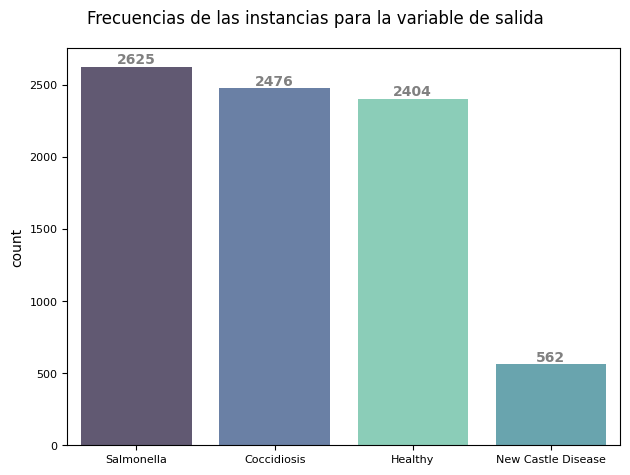

In [15]:
# Visualize the frequency of instances
bar_plot(df, 'label', 'Frecuencias de las instancias para la variable de salida')

In [16]:
# Check nulls, data types, and file size
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8067 entries, 0 to 8066
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  8067 non-null   object
 1   label   8067 non-null   object
dtypes: object(2)
memory usage: 126.2+ KB


El archivo original con las etiquetas contiene 8067 instancias y 2 columnas, ambas son tipo object. Las instancias están clasificadas originalmente en 4 enfermedades diferentes: Salmonella, Coccidiosis, New Castle Disease y Healthy. De acuerdo con la información mostrada, no hay valores nulos en ninguna columna. Además, la base de datos ocupa 126.2+ KB, y es fácil de procesar en términos de almacenamiento y carga.

Los datos almacenados como "uint8" son variables que almacenan números enteros de 8 bits sin signo. Por lo tanto, solo pueden representar valores enteros no negativos. Indica que el número se almacena en 8 bits de memoria. Así, un número de 8 bits puede representar 2^8 (256) valores diferentes, que van desde 0 hasta 255, y es precisamente el rango de valores para cada pixel de la imágen a color.

En la carpeta original hay menos imagenes de las que se registran en el archivo .csv (5030 versus 8067). Esto, porque las imágenes escogidas, corresponden solamente a aquellas con clase "Salmonella" y "Healthy". A continuación, se realiza una limpieza del archivo .csv para dejar solo las dos clases de interés:

## Images

In [17]:
images_metadata = []

# Ensure paths contain directories with image files
image_directories = [test_healthy_dir, test_salmo_dir, train_healthy_dir, train_salmo_dir, validation_healthy_dir,validation_salmo_dir ]

for directory in image_directories:
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path):  # Check if it's a file, not a directory
            img = mpimg.imread(img_path)
            category = directory.split('/')[-1]
            shape = img.shape
            images_metadata.append({
                'path': img_path,
                'label': category,
                'height': shape[0],
                'width': shape[1],
                'aspect_ratio': shape[0] / shape[1],
                'size' : shape[0] * shape[1],
                'channels' : shape[2],
                'dtype' : img.dtype,
                'pixel_range': f"{img.min()} - {img.max()}"
             })

images_metadata = pd.DataFrame(images_metadata)
images_metadata.head(10)

,path,label,height,width,aspect_ratio,size,channels,dtype,pixel_range
0,/tmp/data2/test/healthy/healthy.261.jpg,healthy,224,224,1.0,50176,3,uint8,12 - 221
1,/tmp/data2/test/healthy/healthy.1396.jpg,healthy,224,224,1.0,50176,3,uint8,27 - 219
2,/tmp/data2/test/healthy/healthy.1226.jpg,healthy,224,224,1.0,50176,3,uint8,14 - 238
3,/tmp/data2/test/healthy/healthy.296.jpg,healthy,224,224,1.0,50176,3,uint8,16 - 255
4,/tmp/data2/test/healthy/healthy.1443.jpg,healthy,224,224,1.0,50176,3,uint8,8 - 255
5,/tmp/data2/test/healthy/healthy.2035.jpg,healthy,224,224,1.0,50176,3,uint8,34 - 230
6,/tmp/data2/test/healthy/pcrhealthy.78.jpg,healthy,224,224,1.0,50176,3,uint8,11 - 255
7,/tmp/data2/test/healthy/healthy.1157.jpg,healthy,224,224,1.0,50176,3,uint8,33 - 255
8,/tmp/data2/test/healthy/pcrhealthy.156.jpg,healthy,224,224,1.0,50176,3,uint8,0 - 255
9,/tmp/data2/test/healthy/healthy.1407.jpg,healthy,224,224,1.0,50176,3,uint8,49 - 213


In [18]:
# Check nulls, data types, and file size
images_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   path          5029 non-null   object 
 1   label         5029 non-null   object 
 2   height        5029 non-null   int64  
 3   width         5029 non-null   int64  
 4   aspect_ratio  5029 non-null   float64
 5   size          5029 non-null   int64  
 6   channels      5029 non-null   int64  
 7   dtype         5029 non-null   object 
 8   pixel_range   5029 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 353.7+ KB


In [19]:
# Check duplicated
df.loc[df.duplicated()]

,images,label


No existen registros duplicados en el archivo con las etiquetas.

# Data visualization

En total, el dataset tiene 2529 imágenes. A continuación, se visualiza cómo está dividido:

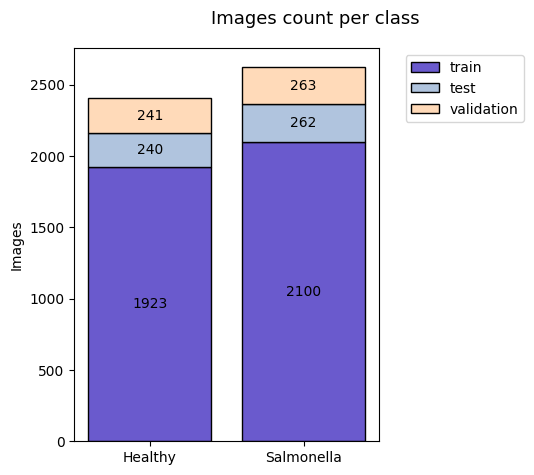

In [20]:
# Plot dataset size and distribution
fig, axes = plt.subplots()
x = np.arange(2)

train = [len(train_healthy_fnames), len(train_salmo_fnames)]
test = [len(test_healthy_fnames), len(test_salmo_fnames)]
validation = [len(validation_healthy_fnames), len(validation_salmo_fnames)]

p1 = axes.bar(x, train, color='slateblue', edgecolor='black')
p2 = axes.bar(x, test, bottom=train, color='lightsteelblue', edgecolor='black')
p3 = axes.bar(x, validation, bottom=np.array(train) + np.array(test), color='peachpuff', edgecolor='black')

plt.ylabel('Images')

# Set the positions and labels for the ticks
plt.xticks(x, ('Healthy', 'Salmonella'), ha='center')
plt.legend((p1[0], p2[0], p3[0]), ('train', 'test', 'validation'), loc='upper right', bbox_to_anchor=(1.5, 1))

for bars in axes.containers:
    axes.bar_label(bars, fmt='%.0f', label_type='center')

fig.suptitle("Images count per class", fontsize=13)
plt.tight_layout()

# Exportar la imagen con tamaño de 3x3 cm
dpi = 300  # Ajusta este valor según tu preferencia de resolución
plt.savefig('grafica.png', dpi=dpi, format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()

Se observa que la variable objetivo presenta dos categorías muy equilibradas. Por lo tanto, el data set está balanceado con un 52,1 % de los registros en la categoría "Salmonella" vs 47,9 % para "Healthy", representando aquellas imágenes que fueron confirmadas con presencia del microorganismo patógeno Salmonella spp. y las que no, respectivamente.

Ahora, se visualizan algunas imágenes de muestra:

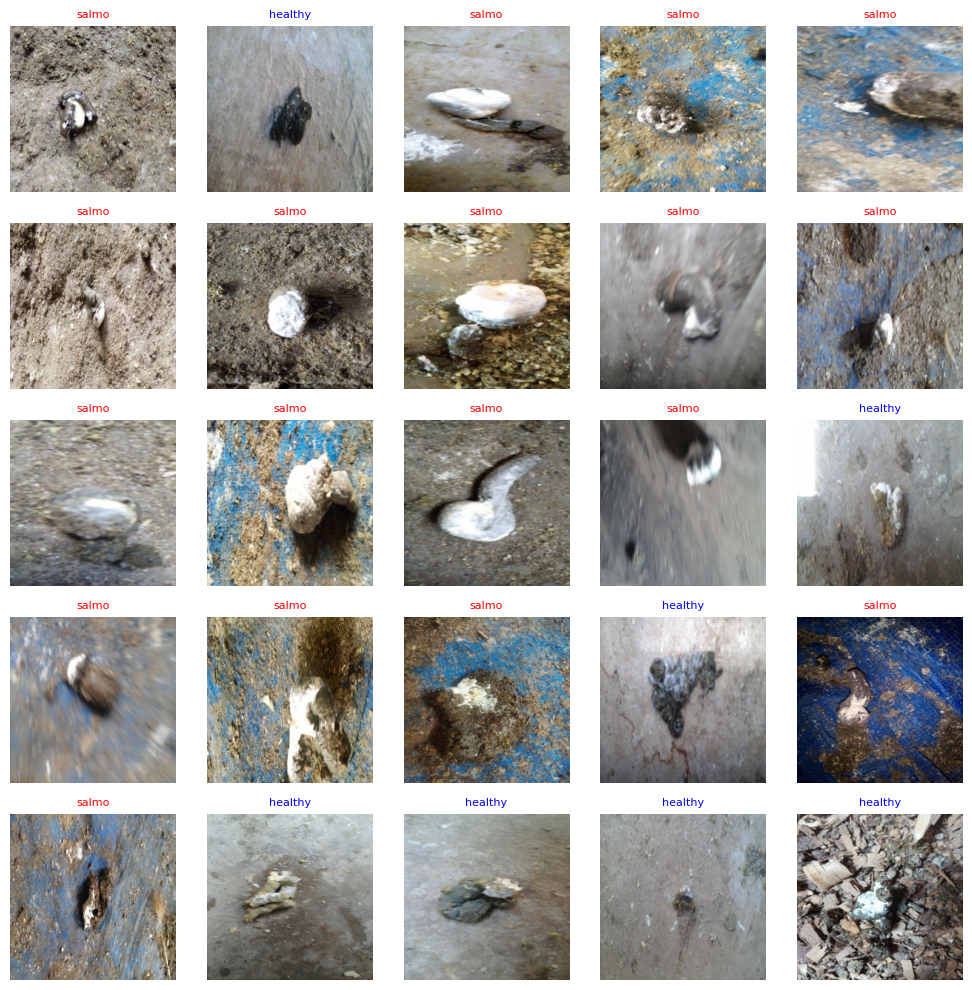

In [21]:
# Using the function to visualize random images and their classes
show_random_images(images_metadata, 25)

Al ejecutar la celda que presenta las imágenes aleatorias, se han evidenciado algunas figuras borrosas y oscuras. Además, el entorno en donde fue tomada la fotografía de las heces es muy variado. Es importante considerar realizar un zoom a las imágenes en donde se pueda mantener las heces y restar detalles alrededor que puedan comprometer el desempeño del modelo de clasificación a entrenar.

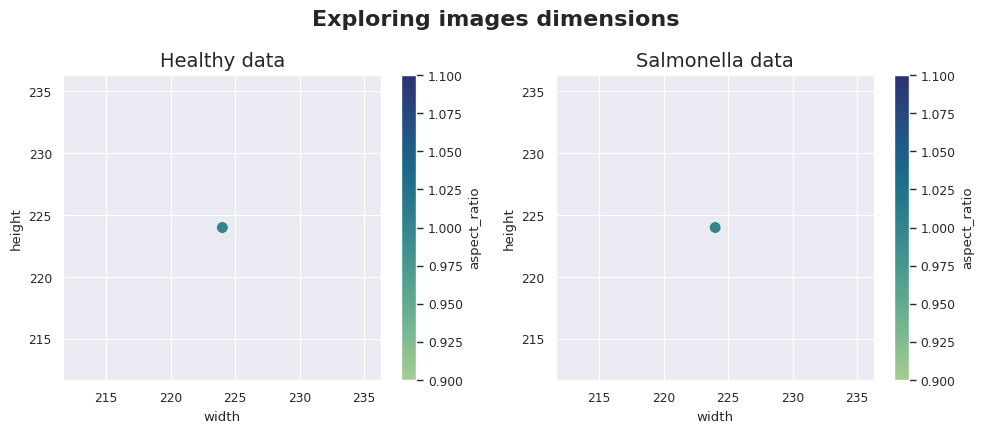

In [22]:
# Plot the figure using the builded function
img_size(images_metadata)